In [707]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [708]:
def relu( x ):
    x = np.maximum(-10,x)
    return np.minimum( 10, x )
#    return np.maximum( 0, x )

In [709]:
def drelu( x ):
    return np.where( (x > -10) & (x < 10) , 1, 0 )
#    return np.where( x > 0, 1, 0 )

In [710]:
def trunC( x ):
    x = np.maximum(-10,x)
    return np.minimum(10, x)

In [711]:
def dtrunC(x):
    return np.where( (x > -10) & (x < 10) , 1, 0 )

In [712]:
def my_Metropolis_Gaussian(p, dp, z0, sigma, d, n_samples=1000, burn_in=0, m=1):
    """
    Metropolis Algorithm using a Gaussian proposal distribution.
    p: distribution that we want to sample from (can be unnormalized)
    dp: the derivative of p
    z0: Initial sample
    sigma: standard deviation of the proposal normal distribution.
    d: the dimension of the vector to simulate
    n_samples: number of final samples that we want to obtain.
    burn_in: number of initial samples to discard.
    m: this number is used to take every mth sample at the end
    """
    samples = np.zeros( ( d, n_samples ) )

    # Store initial value
    samples[ :, 0 ] = np.squeeze( z0 )
    z = z0
    # Compute the current likelihood
    l_cur = p( z )

    # Counter
    it = 0
    

    # Sample outside the for loop
    nsample_trial = 1000
    innov = np.random.normal(loc=0, scale=4, size=( d, nsample_trial + burn_in ) )
    u = np.random.rand( nsample_trial + burn_in )
    subsample = np.zeros( ( d, 1 ) )
    Fisher = 0

    while it < (nsample_trial + burn_in):
        # Random walk innovation on z
        cand = z + innov[ :, it ].reshape( ( d, 1 ) )

        # Compute candidate likelihood
        l_cand = p( cand )

        # Accept or reject candidate
        if l_cand - l_cur > np.log(u[ it ]):
            z = cand
            l_cur = l_cand

        #subsample = np.squeeze( z )
        if it > burn_in:
            subsample = z
            dp_vector = dp( subsample )
            Fisher += np.dot( dp_vector.T, dp_vector )
        
        it = it + 1
     
    Fisher = Fisher / nsample_trial
    sc_optimal = np.sqrt( 2.38 * 2.38 / Fisher / d )
    #sc_optimal = 4
    
    
    
    it = 0 
    # Total number of iterations to make to achieve desired number of samples
    iters = ( n_samples * m ) + burn_in
    innov = np.random.normal(loc=0, scale=sc_optimal, size=( d, iters ) )
    u = np.random.rand( iters )
    z = z0
    
    while it < iters:
        # Random walk innovation on z
        cand = z + innov[ :, it ].reshape( ( d, 1 ) )

        # Compute candidate likelihood
        l_cand = p( cand )

        # Accept or reject candidate
        if l_cand - l_cur > np.log(u[ it ]):
            z = cand
            l_cur = l_cand

        # Only keep iterations after burn-in and for every m-th iteration
        if it > burn_in and it % m == 0:
            samples[ :, ( it - burn_in ) // m ] = np.squeeze( z )

        it = it + 1

    return samples


In [713]:
def p( x, C, W, b, sigma, lam_one ):
    
    phi = trunC(C) * relu( np.matmul( W, x ) + b )
    
    #theta_sq_norm = C**2 + np.linalg.norm( W, 
    #                axis = 1, keepdims = True )**2 + b**2
    
    x_sq_norm = x**2
    
    #result = np.exp( - 2 / ( sigma * sigma ) * ( np.mean( phi - lam * theta_sq_norm, axis = 0 )
    #                     + lam_one * x_sq_norm ) )
    #result = np.exp( - 2 / ( sigma * sigma ) * ( np.mean( phi , axis = 0 )
    #                     + lam_one * x_sq_norm ) )
    
    result =  - 2 / ( sigma * sigma ) * ( np.mean( phi , axis = 0 )
                         + lam_one * x_sq_norm ) 
    
    result = np.squeeze( result )
    
    return result

In [714]:
def dp( x, C, W, b, sigma, lam_one ):
    
    dphi = trunC(C) * drelu( np.matmul( W, x ) + b ) * W
    
    result = - 2 / ( sigma * sigma ) * ( ( np.mean( dphi, axis = 0, keepdims = True ) ).T + 2 * lam_one * x )
    
    return result

In [715]:
def initialize_parameters( n_y, n_n ):
    """
    Arguments:
    n_y -- the number of features in the data
    n_n -- the number of neurons (number of samples of nu)
    
    Returns:
    parameters -- python dictionary containing parameters "C", "W", "b"
                    C -- weight scalars of shape (n_n, 1)
                    W -- weight vector of shape (n_n, n_y)
                    b -- bias scalar of shape (n_n, 1)
    """
    
    parameters = {}

    parameters[ 'C' ] = np.random.randn( n_n, 1 )*10
    parameters[ 'Cv'] = np.random.randn( n_n, 1 ) *  5
    
    parameters[ 'W' ] = np.random.randn( n_n, n_y )*10
    parameters[ 'Wv' ] = np.random.randn( n_n, n_y ) * 5
    
    parameters[ 'b' ] = np.random.randn( n_n, 1 )*10
    parameters[ 'bv' ] = np.random.randn( n_n, 1 ) * 5

        
    return parameters

In [716]:
def forward_propagation( parameters, X, Z, dt, lam_one, eta, lam, gamma, sigma ):
    """
    Implement forward propagation (see formulas for dX, dTheta)
    
    Arguments:
    parameters -- current value of Theta = ( C, W, b )
    X -- samples of the current distribution mu, array of size ( n_y, n_x )
    z -- samples of the distribution mu_star, array of size ( n_y, n_z )
    dt, lam, eps, sigma -- parameters of gradient update rule
    
    Returns:
    X -- updated value of X
    parameters -- updated value of parameter Theta
    """
    
    C = parameters[ 'C' ]
    Cv = parameters[ 'Cv' ]
    
    W = parameters[ 'W' ]
    Wv = parameters[ 'Wv' ]
    
    b = parameters[ 'b' ]
    bv = parameters[ 'bv' ]
    
    n_y, n_x = X.shape
    n_z = Z.shape[ 1 ]
    n_n = C.shape[ 0 ]
    
    # Update X using metropolis-hastings
    X = my_Metropolis_Gaussian( lambda x: p( x, C, W, b, sigma, lam_one ),
                                lambda x: dp( x, C, W, b, sigma, lam_one ),
                               z0 = np.zeros( ( n_y, 1 ) ), sigma = 0.1, d = n_y, n_samples = n_x, burn_in = 1000, m = 1 )
    #print( X.shape )
    
    LX = np.matmul( W, X ) + b
    AX = relu( LX )
    dAX = drelu( LX )
    BX = trunC(C) * dAX
    
    LZ = np.matmul( W, Z ) + b
    AZ = relu( LZ )
    dAZ = drelu( LZ )
    BZ = trunC(C) * dAZ 
    
    # Implement dTheta formula
    dc_dF_dnu = ( np.mean( AX, axis = 1, keepdims = True ) - np.mean( AZ, axis = 1, keepdims = True ) ) * dtrunC(C)
    
    dCv = dc_dF_dnu * dt - 2 * (lam * C + gamma * Cv) * dt + sigma * np.random.randn( n_n, 1 ) * np.sqrt( dt )
    parameters[ 'Cv' ] = Cv + dCv
    parameters[ 'C' ]  = C + eta* Cv * dt
    
    dw_dF_dnu = np.matmul( BX, np.transpose( X, 
                                            ( 1, 0 ) ) ) / n_x - np.matmul( BZ, np.transpose( Z, ( 1, 0 ) ) ) / n_z 
    dWv = dw_dF_dnu * dt - 2 * (lam * W + gamma * Wv) * dt + sigma * np.random.randn( n_n, n_y ) * np.sqrt( dt )
    parameters[ 'Wv' ] = Wv + dWv
    parameters[ 'W' ]  = W + eta* Wv * dt
    
    db_dF_dnu = np.mean( BX, axis = 1, keepdims = True ) - np.mean( BZ, axis = 1, keepdims = True )
    dbv = db_dF_dnu * dt - 2 * (lam * b + gamma * bv) * dt + sigma * np.random.randn( n_n, 1 ) * np.sqrt( dt )
    parameters[ 'bv' ] = bv + dbv
    parameters[ 'b' ]  = b + eta* bv * dt
    
    return ( X, parameters )

In [717]:
def compute_cost( parameters, X, Z ,eta):
    """
    Implement the cost function defined by F.

    Arguments:
    parameters -- the parameters theta = ( C, W, b )
    X -- samples of the distribution mu, shape (n_y, n_x)
    Z -- samples of the distribution mu_star, shape (n_y, n_z)

    Returns:
    cost 
    """
    C = parameters[ 'C' ]
    Cv = parameters[ 'Cv' ]
    
    W = parameters[ 'W' ]
    Wv = parameters[ 'Wv' ]
    
    b = parameters[ 'b' ]
    bv = parameters[ 'bv' ]
    
    
    n_n = C.shape[0]
    
    cost = np.mean( - np.mean( trunC(C) * relu( np.matmul( W, X ) + b ), axis = 1) + 
                   np.mean( trunC(C) * relu( np.matmul( W, Z ) + b ), axis = 1),  axis = 0 ) + 0.5* eta * np.sum(Cv*Cv + Wv*Wv + bv*bv)/n_n
    
    cost = np.squeeze(cost)      # To make sure cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

In [718]:
def nn_model(Z, n_n, n_x, minibatch_size = 32, dt = 0.05, lam_one = 0.01, eta = 0.2, lam = 0.1, gamma = 0.5, sigma = 0.1, 
                  num_epochs = 1000, print_cost=True ):
    """
    Implements a 1-layer neural network.
    
    Arguments:
    Z -- data, samples of the distribution mu_star, numpy array of shape (n_y, n_z)
    n_n -- number of neurons in each layer (number of samples of distribution nu)
    n_x -- number of samples of the distribution mu
    minibatch_size -- size of minibatch
    dt -- parameter of the gradient update rule
    lam -- parameter of the gradient update rule
    eps -- parameter of the gradient update rule
    sigma -- parameters of the gradient update rule
    num_epochs -- number of epochs of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    costs -- list of costs F calculated at each iteration of the optimization loop
    X -- samples of the learned distribution mu, array of size ( n_y, n_x ) 
    """

    #np.random.seed(1)
    costs = []   # keep track of cost
    
    
    ( n_y, n_z ) = Z.shape
    
    #seed = 1 # for constructing minibatches
    
    # Parameters initialization.
    parameters = initialize_parameters( n_y, n_n )
    X = np.random.randn( n_y, n_x )

    # Loop (optimization)
    for i in range(0, num_epochs):
          
                
        # Forward propagation.
        X, parameters  = forward_propagation( parameters, X, Z, dt, lam_one, eta, lam, gamma, sigma )
        
        # Compute cost.
        cum_cost = compute_cost( parameters, X, Z ,eta)
                
        costs.append(cum_cost)
        if print_cost:
            print ("Cost after epoch %i: %f" %(i, cum_cost))

    
    return ( parameters, costs, X )

In [735]:
# Test on a simple distribution
Z = np.random.exponential( 1, ( 1, 1000 ) )
#a =  np.random.randn( 1, 1000 ) + 1
#b = np.random.randn(  1, 1000 ) + 4
#Z= np.concatenate((b,a), axis=1)
#Z = 2 * np.random.rand( 1, 1000 )
parameters, costs, X = nn_model( Z, n_n = 3000, n_x =1000, dt=0.01, lam_one = 0, eta =0.3, lam = 0., gamma = 2,
                                sigma = 0.4, num_epochs = 100)

Cost after epoch 0: 10.468301
Cost after epoch 1: 9.697639
Cost after epoch 2: 8.927752
Cost after epoch 3: 8.265469
Cost after epoch 4: 7.650027
Cost after epoch 5: 7.077109
Cost after epoch 6: 6.536827
Cost after epoch 7: 6.023486
Cost after epoch 8: 5.602775
Cost after epoch 9: 5.173156
Cost after epoch 10: 4.793583
Cost after epoch 11: 4.441375
Cost after epoch 12: 4.118936
Cost after epoch 13: 3.816502
Cost after epoch 14: 3.537140
Cost after epoch 15: 3.280898
Cost after epoch 16: 3.049499
Cost after epoch 17: 2.804009
Cost after epoch 18: 2.623097
Cost after epoch 19: 2.438312
Cost after epoch 20: 2.272778
Cost after epoch 21: 2.061906
Cost after epoch 22: 1.960640
Cost after epoch 23: 1.821513
Cost after epoch 24: 1.688434
Cost after epoch 25: 1.568115
Cost after epoch 26: 1.465592
Cost after epoch 27: 1.388352
Cost after epoch 28: 1.286971
Cost after epoch 29: 1.186668
Cost after epoch 30: 1.117293
Cost after epoch 31: 1.051332
Cost after epoch 32: 0.988507
Cost after epoch 33

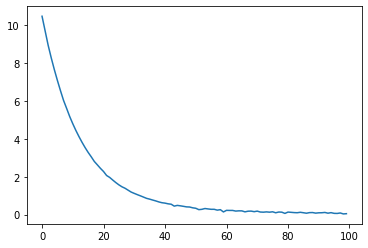

In [736]:
plt.plot( costs )

(array([0.24629224, 0.92302045, 0.49258448, 0.12429702, 0.03682875,
        0.01611258, 0.01150898, 0.10588265, 0.07826109, 0.07595929,
        0.04833773, 0.03222515, 0.02071617, 0.02301797, 0.01841437,
        0.00920719, 0.00690539, 0.00460359, 0.01381078, 0.01381078]),
 array([-0.15426959,  0.28017366,  0.7146169 ,  1.14906014,  1.58350339,
         2.01794663,  2.45238987,  2.88683312,  3.32127636,  3.7557196 ,
         4.19016285,  4.62460609,  5.05904934,  5.49349258,  5.92793582,
         6.36237907,  6.79682231,  7.23126555,  7.6657088 ,  8.10015204,
         8.53459528]),
 <a list of 20 Patch objects>)

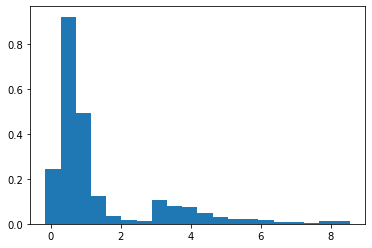

In [737]:
plt.hist( X.T, density = True, stacked = True, bins = 20 )
#x_points = np.linspace( 0, 4, 100 )
#exp_density = np.exp( - x_points )
#plt.plot( x_points, exp_density )

(array([277., 191., 147., 101.,  62.,  69.,  42.,  34.,  22.,  24.,   8.,
          7.,   2.,   5.,   3.,   0.,   3.,   1.,   1.,   1.]),
 array([1.80269289e-03, 3.30595456e-01, 6.59388219e-01, 9.88180982e-01,
        1.31697374e+00, 1.64576651e+00, 1.97455927e+00, 2.30335203e+00,
        2.63214480e+00, 2.96093756e+00, 3.28973032e+00, 3.61852308e+00,
        3.94731585e+00, 4.27610861e+00, 4.60490137e+00, 4.93369414e+00,
        5.26248690e+00, 5.59127966e+00, 5.92007243e+00, 6.24886519e+00,
        6.57765795e+00]),
 <a list of 20 Patch objects>)

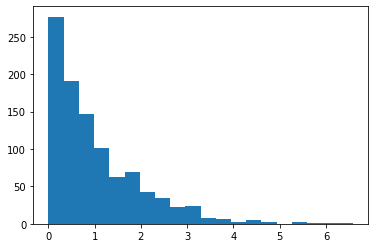

In [722]:
plt.hist(Z.T, 20 )